In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.data_wrangling as data
import functions.eddy_feedback as ef

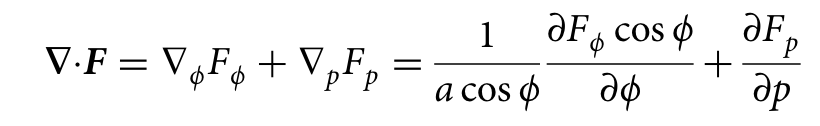

# SPARC SRIP Data

- EPF_phi_pr (epfy) = [m3 s-2]
- EPFD_phi_pr (div1) = [m s-2]

In [2]:
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/ZMD_monthly*')

srip = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ucomp': ucomp.u } )
srip

<xarray.Dataset>
Dimensions:      (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time         (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:...
  * pressure     (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude     (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
Data variables:
    EPF_phi_pr   (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_pr  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    ucomp        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>

In [3]:
srip.pressure

<xarray.DataArray 'pressure' (pressure: 22)>
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    7.,    5.,    3.,
          2.,    1.], dtype=float32)
Coordinates:
  * pressure  (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
Attributes:
    description:    Pressure levels
    units:          hPa
    standard_name:  air_pressure

## Convert units

In [106]:
# constants
p0 = 1e3        # [hPa]

# define dimensions
plevs = srip.pressure.values
lat = srip.latitude.values

p_ratio = np.repeat(plevs/p0, lat.size)
# p_ratio = np.flip(p_ratio)
p_ratio

array([1.   , 1.   , 1.   , ..., 0.001, 0.001, 0.001], dtype=float32)

In [107]:
p_ratio = p_ratio.reshape( (plevs.size, lat.size) )

epfy = srip['EPF_phi_pr']
epfy = epfy * p_ratio
# epfy

## Calculate divergence

![DivF](DivF.png)

In [108]:
# set variables/constants
a = 6.371e6     # [m]
lat = np.deg2rad(srip.latitude)     # np.cos requires radians input
coslat = np.cos(lat)

# components
deriv = epfy * coslat
R = 1 / a*coslat

In [109]:
# Take derivative using np.gradient
# deriv1 = np.gradient(deriv.values, np.deg2rad(lat), axis=1)

# Try built-in xarray method
deriv1 = deriv.differentiate('latitude', edge_order=2)

# deriv1 = deriv1 * R 
# deriv1

# Check Data

In [110]:
srip

<xarray.Dataset>
Dimensions:      (time: 235, pressure: 22, latitude: 73)
Coordinates:
  * pressure     (pressure) float32 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude     (latitude) float32 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * time         (time) datetime64[ns] 1958-03-01 1958-06-01 ... 2016-09-01
Data variables:
    EPF_phi_pr   (time, pressure, latitude) float32 nan nan nan ... nan nan nan
    EPFD_phi_pr  (time, pressure, latitude) float32 nan nan nan ... nan nan nan
    ucomp        (time, pressure, latitude) float32 1.72e-05 ... -4.466e-05

ubar NaNs: False
epfy NaNs: True




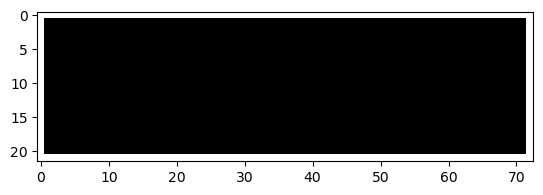

In [111]:
# take DJF mean
srip = data.seasonal_mean(srip)

print(f'ubar NaNs: {np.any(np.isnan(srip.ucomp.values))}')
print(f'epfy NaNs: {np.any(np.isnan(srip.EPF_phi_pr.values))}')
print('\n')

# find NaNs
is_nan_srip_epfy = np.isnan(srip.EPF_phi_pr)
is_nan_srip_epfy = is_nan_srip_epfy.mean('time')

# plot missing values
plt.imshow(is_nan_srip_epfy.values, cmap='gray')
plt.show()

ubar NaNs: False
div1 NaNs: True




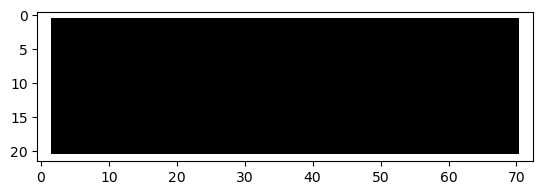

In [112]:
# take DJF mean
srip = data.seasonal_mean(srip)

print(f'ubar NaNs: {np.any(np.isnan(srip.ucomp.values))}')
print(f'div1 NaNs: {np.any(np.isnan(srip.EPFD_phi_pr.values))}')
print('\n')

# find NaNs
is_nan_srip_div1 = np.isnan(srip.EPFD_phi_pr)
is_nan_srip_div1 = is_nan_srip_div1.mean('time')

# plot missing values
plt.imshow(is_nan_srip_div1.values, cmap='gray')
plt.show()

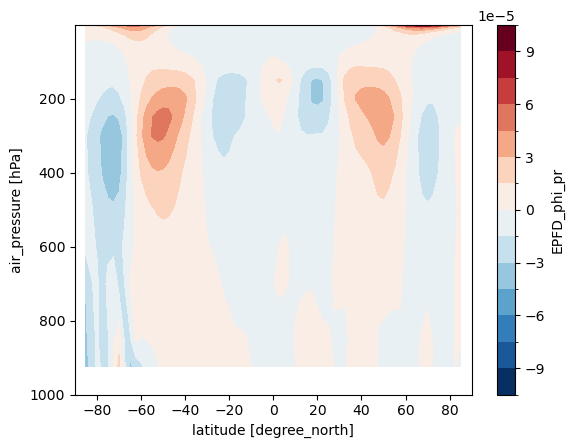

In [113]:
srip.EPFD_phi_pr.mean('time').plot.contourf(levels=20, yincrease=False)

### My calculations

div1 NaNs: True




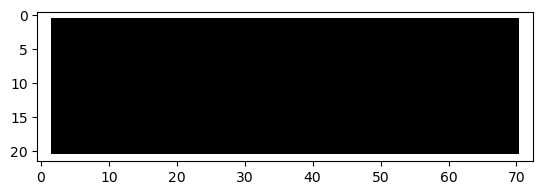

In [114]:
# take DJF mean
deriv1 = data.seasonal_mean(deriv1)

print(f'div1 NaNs: {np.any(np.isnan(deriv1.values))}')
print('\n')

# find NaNs
is_nan_deriv1 = np.isnan(deriv1)
is_nan_deriv1 = is_nan_deriv1.mean('time')

# plot missing values
plt.imshow(is_nan_deriv1.values, cmap='gray')
plt.show()

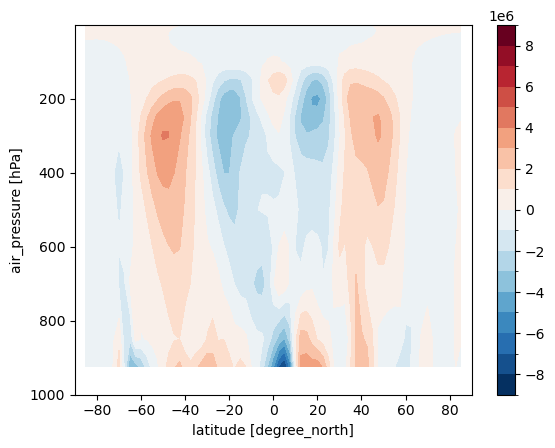

In [115]:
deriv1.mean('time').plot.contourf(levels=20, yincrease=False)

In [116]:
print(srip.EPFD_phi_pr.shape)
print(deriv1.values.shape)

(235, 22, 73)
(235, 22, 73)


In [117]:
np.testing.assert_allclose(srip.EPFD_phi_pr.values, deriv1.values, rtol=0.01)

AssertionError: 
Not equal to tolerance rtol=0.01, atol=0

Mismatched elements: 324300 / 377410 (85.9%)
Max absolute difference: 20427334.
Max relative difference: 1.
 x: array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan, -3.607254e-05, ...,...
 y: array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan, -1.795574e+05, ...,...